In [1]:
#in case of any problems navigate to edit then notebook settings --> hardware accelerator, set it to gpu, and then click save.
#checks GPU status if using an NVIDIA graphics card.
#displays memory usage, temperature, and active processes.
#also useful for debugging GPU-related performance issues.
!nvidia-smi

Thu May  8 00:31:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#imports the os module, which handles operating system functions.
#gets the current working directory,which is useful when managing file paths dynamically.
#To make it easier to manage datasets images and models we create a HOME constant.
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
#installing Ultralytics library, which provides advanced object detection tools.
# This package includes YOLO models and simplifies deep learning workflows
# Required for running custom YOLO11 detection models
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


In [4]:
#create a directory named "datasets" inside the current working directory
#this will store the dataset files needed for training and testing
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow
#import the Roboflow module to interact with datasets using its API
from roboflow import Roboflow
#authenticate with the Roboflow API using an access key
#this grants permission to access and download the required dataset
rf = Roboflow(api_key="TgpEeIFcI6pkkBERf0U3")
#access the specific project within the skin disease workspace.
#this project contains skin disease images and annotations for model training
project = rf.workspace("skin-disease").project("skin-disease-vrvtv")
#selects version 6 of the dataset for downloading
#different versions may contain updates or improvements in data quality
version = project.version(6)
dataset = version.download("yolov11")
#the dataset will be saved locally for training object detection


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


In [6]:
#modify the dataset configuration file (data.yaml) to adjust paths for training, validation, and testing
#the sed command deletes the last three lines of the file to remove unwanted entries.
!sed -i '$d' {dataset.location}/data.yaml   #deletes the last line
!sed -i '$d' {dataset.location}/data.yaml   #deletes the second to last line
!sed -i '$d' {dataset.location}/data.yaml   #deletes the third to last line

#append new files path to specify where training, validattion & test images are located.
#the dataset's image directories are set correctly for YOLOv11 training
!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [7]:
#changes the current working directory back to the main project folder.
#this ensures that the training command runs in the correct directory
%cd {HOME}

#training the YOLO11 model for object detection using the specified dataset.
#the training process includes the following;
# task=detect → Specifies that this is an object detection task
#mode=train → Indicates that the model is being trained
#model=yolo11s.pt → Uses the pretrained YOLO11 small model as the base
#data={dataset.location}/data.yaml → Loads dataset paths from the YAML configuration file
#epochs=10 → Trains the model for 10 epochs (adjust if more training is needed)
#imgsz=640 → Sets the image size to 640x640 pixels for input
#plots=True → Enables plotting of training metrics to visualize progress
!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 203MB/s]
Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Skin-Disease-6/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

In [8]:
#list the contents of the training output directory.
#this will display files generated during model training, including logs, checkpoints & evaluation results
!ls {HOME}/runs/detect/train/

args.yaml			 PR_curve.png	   val_batch0_labels.jpg
confusion_matrix_normalized.png  R_curve.png	   val_batch0_pred.jpg
confusion_matrix.png		 results.csv	   val_batch1_labels.jpg
F1_curve.png			 results.png	   val_batch1_pred.jpg
labels_correlogram.jpg		 train_batch0.jpg  val_batch2_labels.jpg
labels.jpg			 train_batch1.jpg  val_batch2_pred.jpg
P_curve.png			 train_batch2.jpg  weights


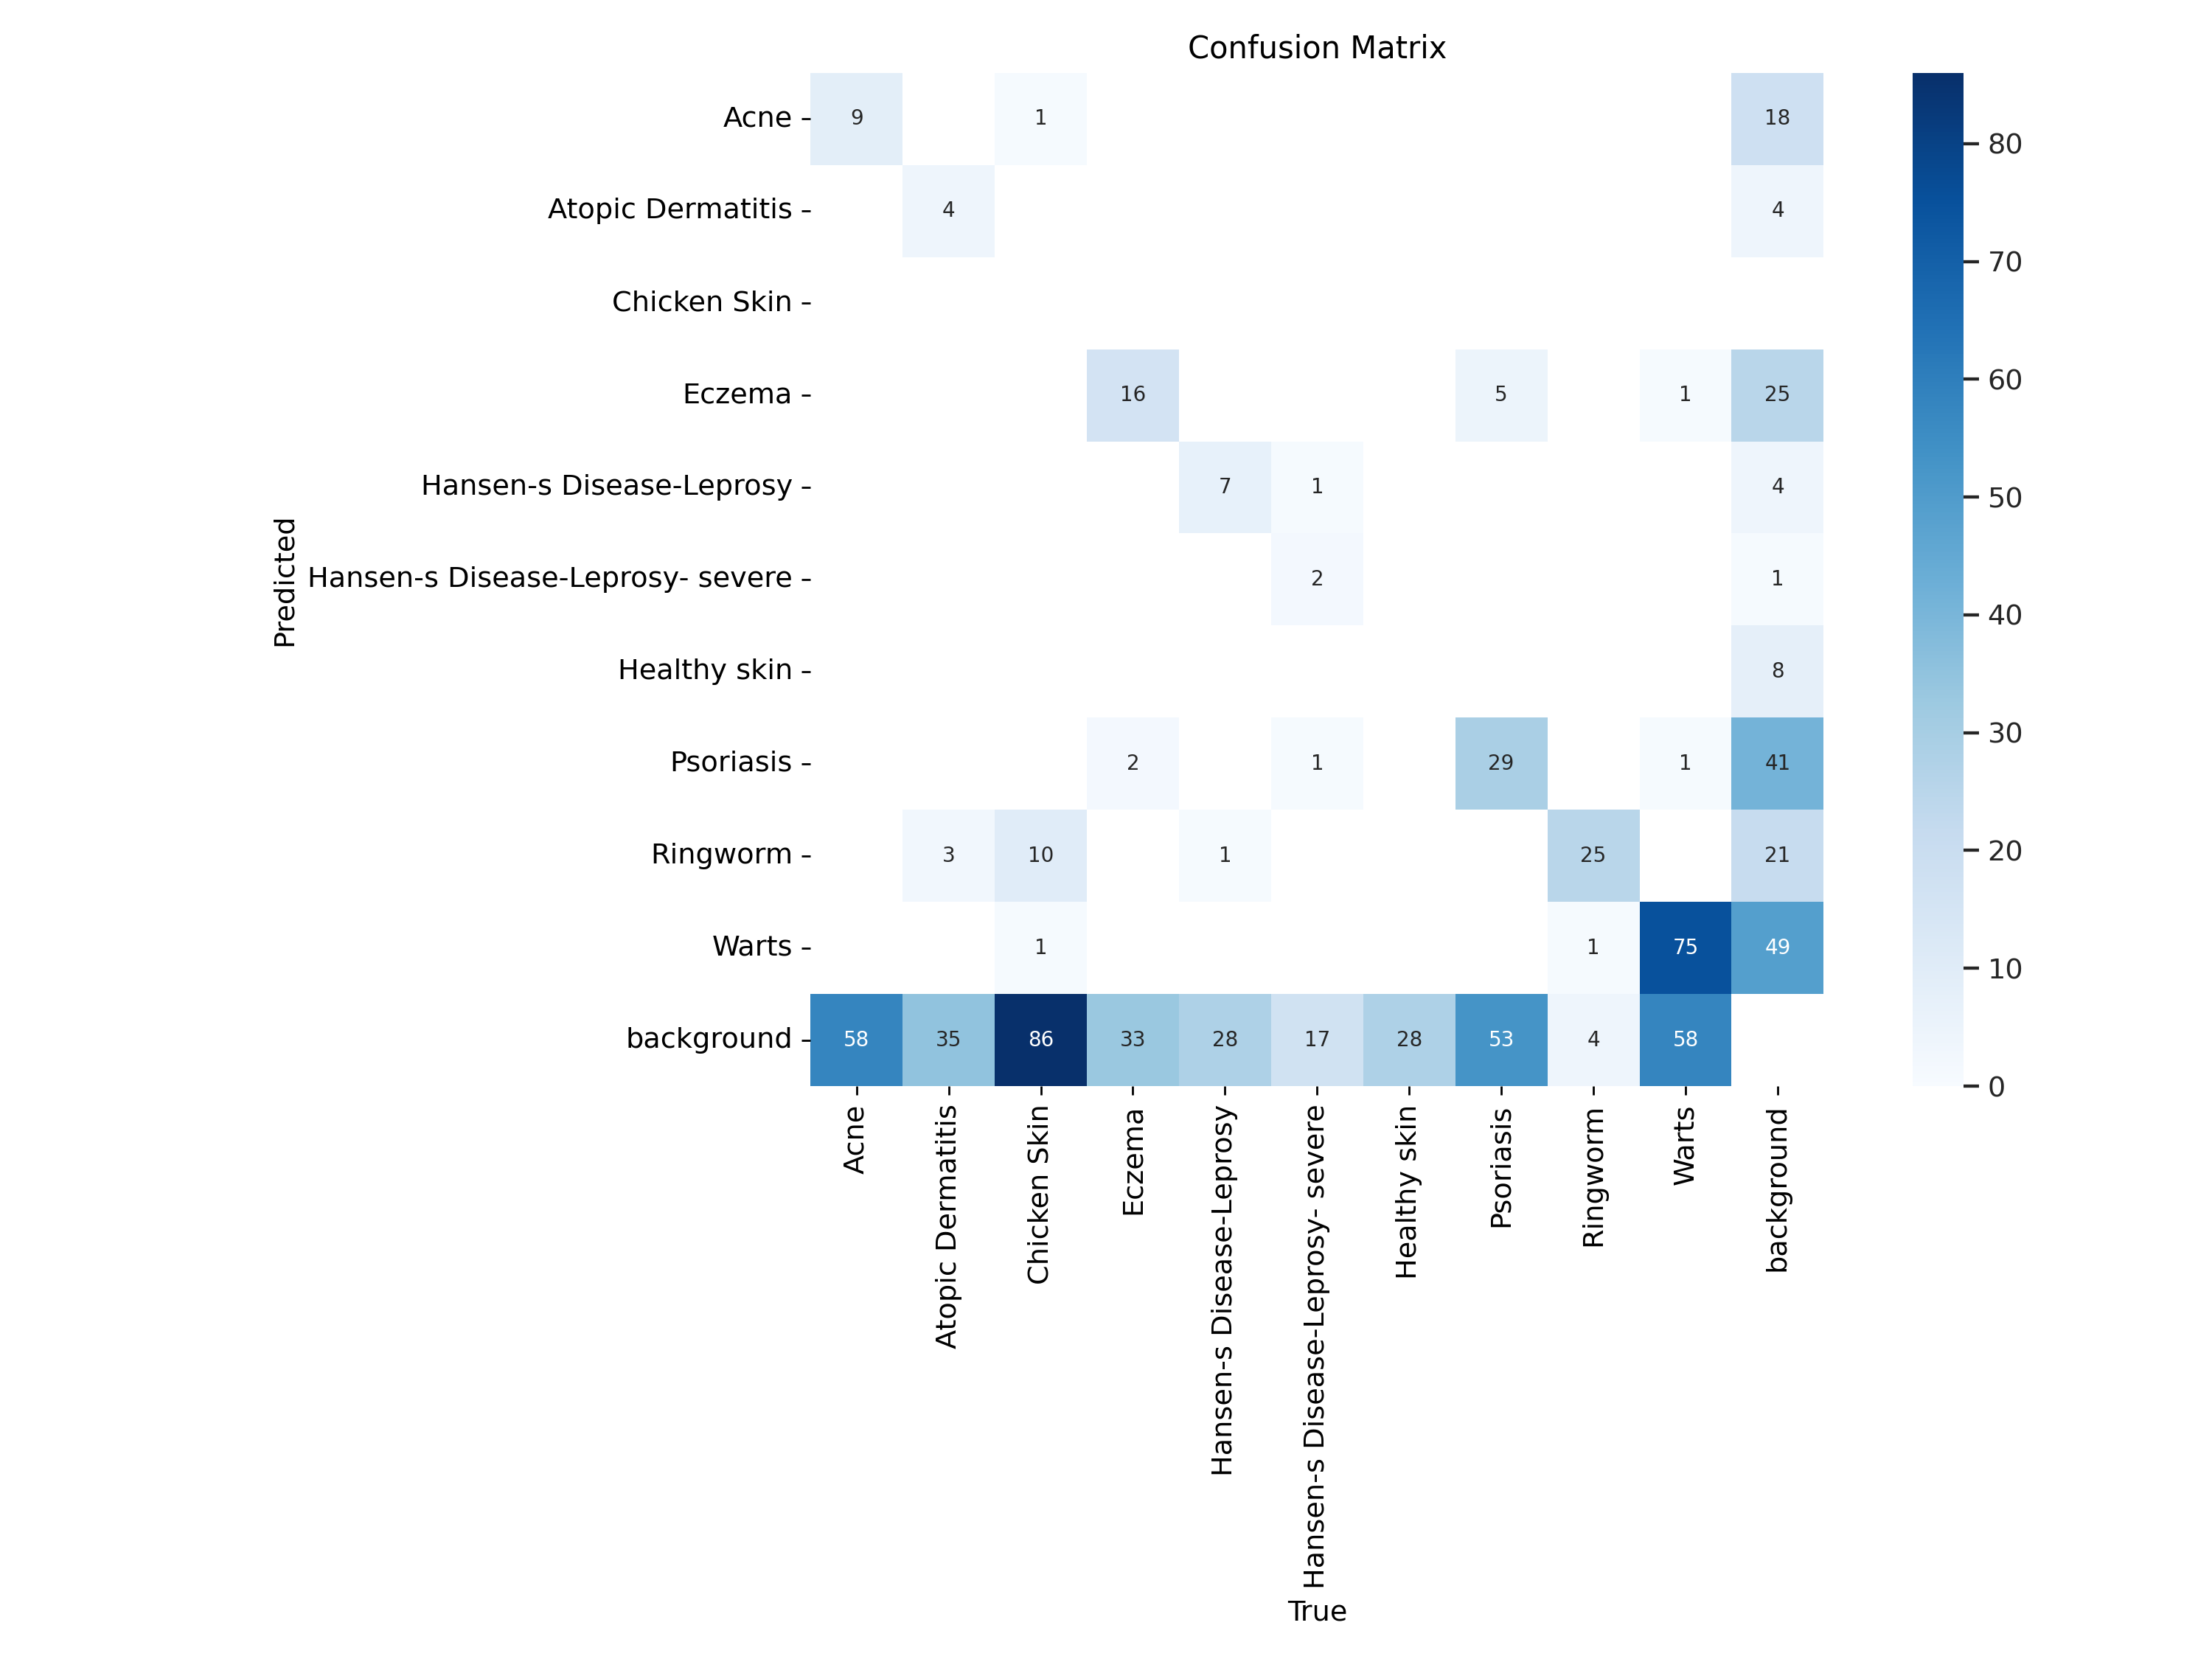

In [9]:
#this allows visualisation of training results directly within the notebook interface.
from IPython.display import Image as IPyImage
# The confusion matrix helps evaluate model performance by showing accuracy across different classes.

# Key observations:
#background class has the highest correct detections (86), meaning the model is good at ignoring non skin elements.
#warts class has strong accuracy (75 correct), but some misclassified as ringworm and eczema.
#acne detection is weaker (9 correct), with 18 cases misclassified as background.The model struggles to differentiate acne from normal skin,
#likely due to subtle visual differences. More labeled acne images and improved preprocessing may enhance accuracy.
#healthy Skin only has 8 correct detections, suggesting the model struggles with normal skin identification.
#eczema shares visual characteristics with warts, causing detection errors. Better feature
#extraction or refining the models training data can help distinguish eczema accurately .

# Overall, acne and eczema detection require further optimization, particularly in training data diversity
# and distinguishing features between similar skin conditions. the model performs well on certain conditions like "Warts" and "Background," but struggles with
# distinguishing visually similar conditions. Improvements could include class balancing, more diverse training images,
# and refining preprocessing techniques
IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

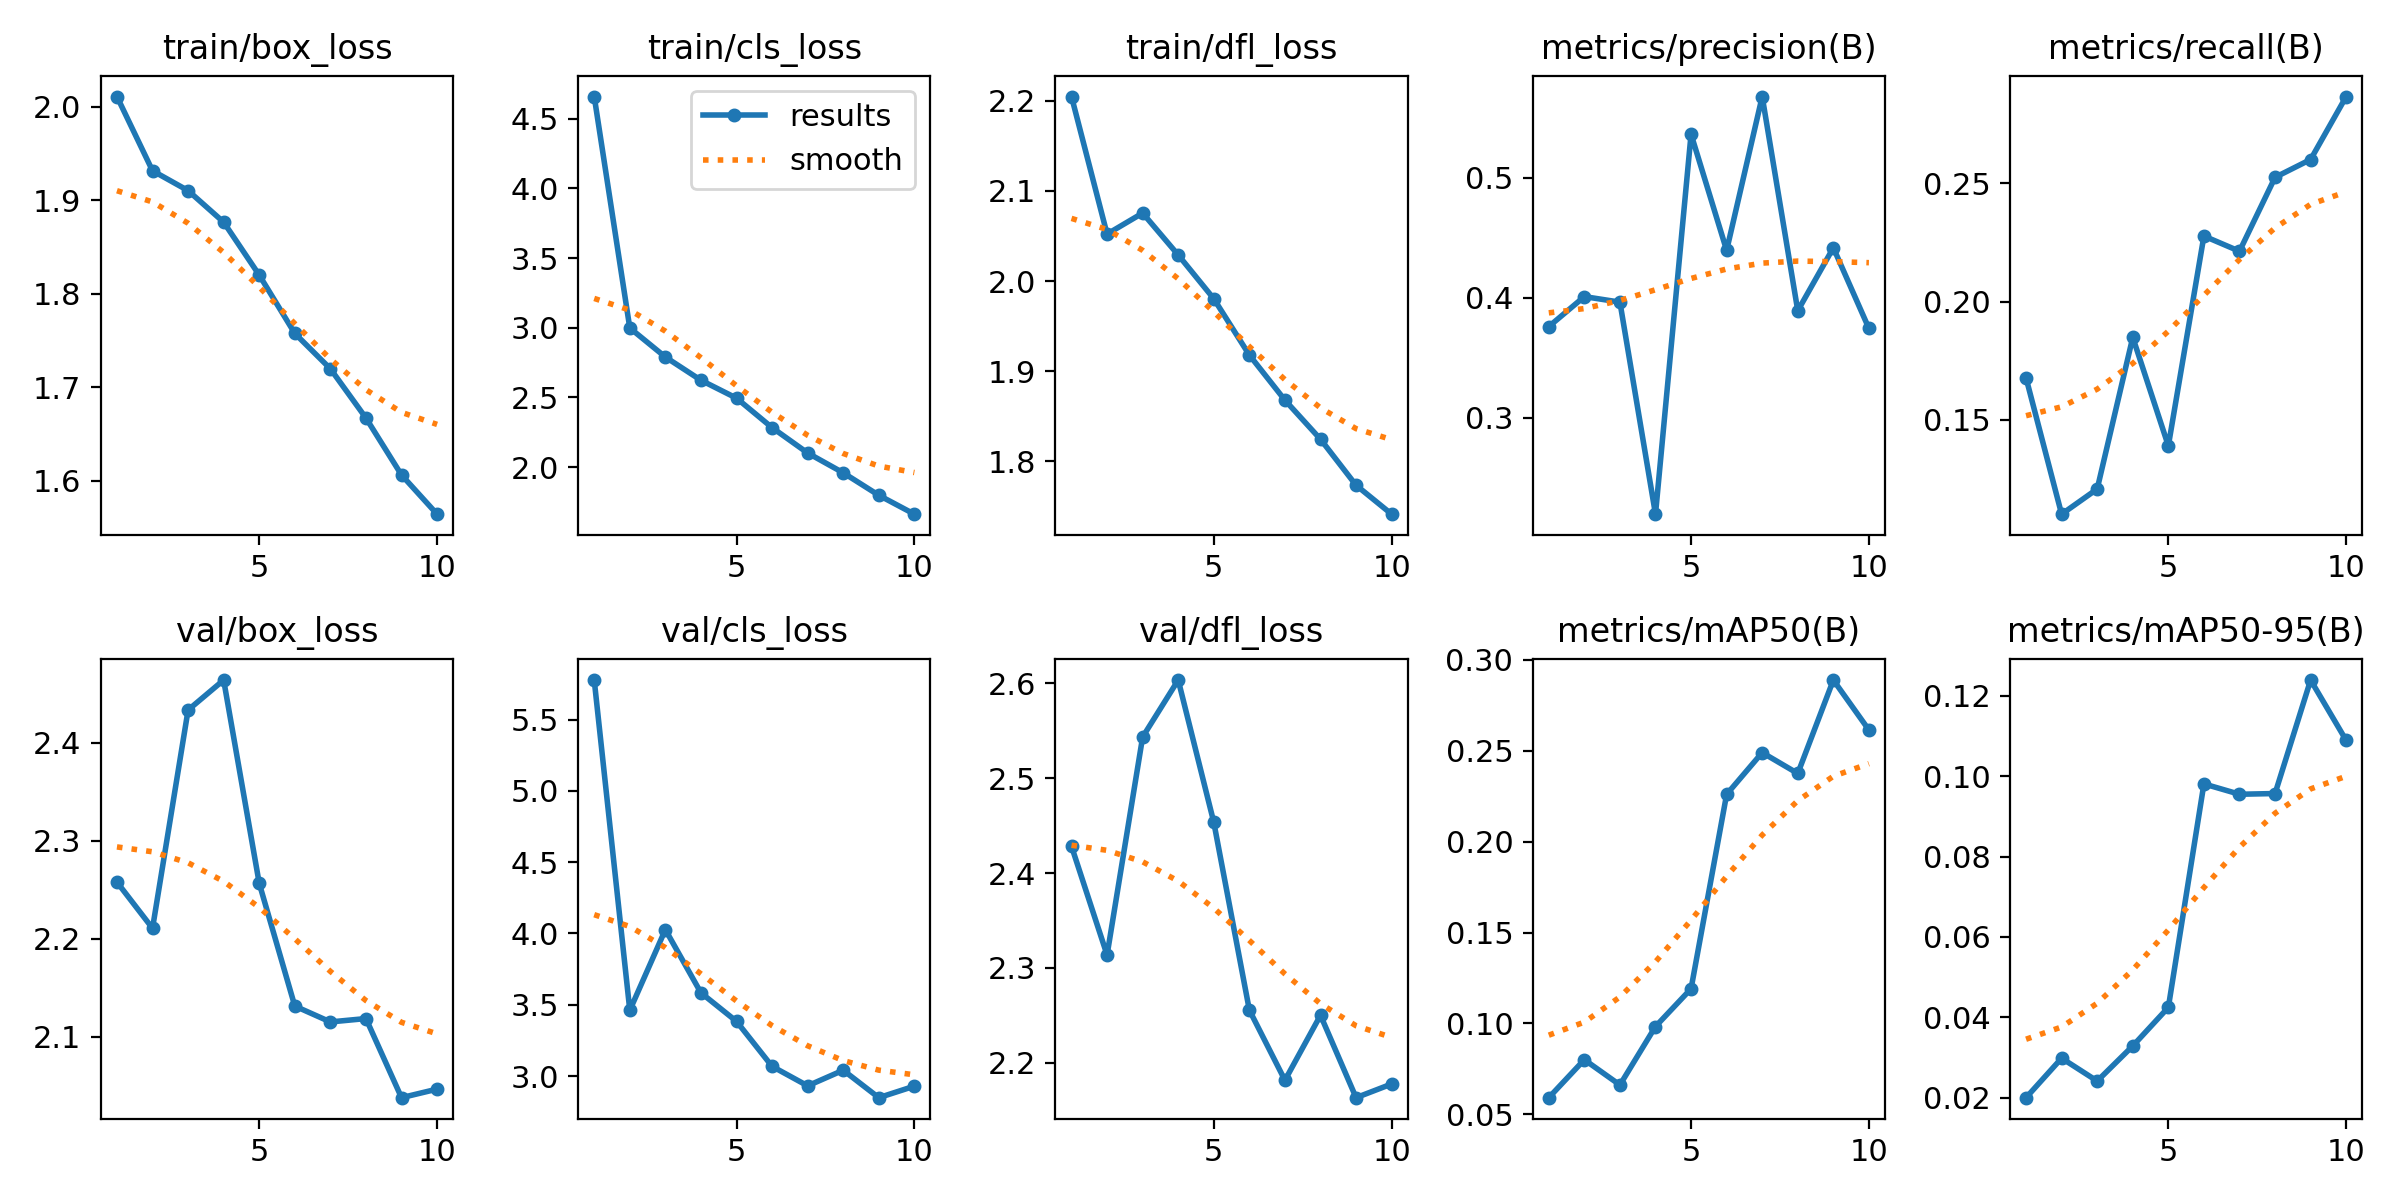

In [15]:
#displays the training performance metrics as a set of line graphs
#helps analyze loss trends and improvements across 10 epochs

# Key Metrics:
#train/box_loss, train/cls_loss & train/dfl_loss measure loss during model training
#val/box_loss, val/cls_loss & val/dfl_loss evaluates loss during validation
#metrics/precision(B) shows how well the model detects skin conditions correctly
#metrics/recall(B) indicates how many relevant conditions the model successfully identifies
#metrics/mAP50(B) and "metrics/mAP50-95(B)" → Measure overall detection accuracy at different confidence thresholds

# The blue line represents training progress, while the orange dashed line provides a smoothed trend
#
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

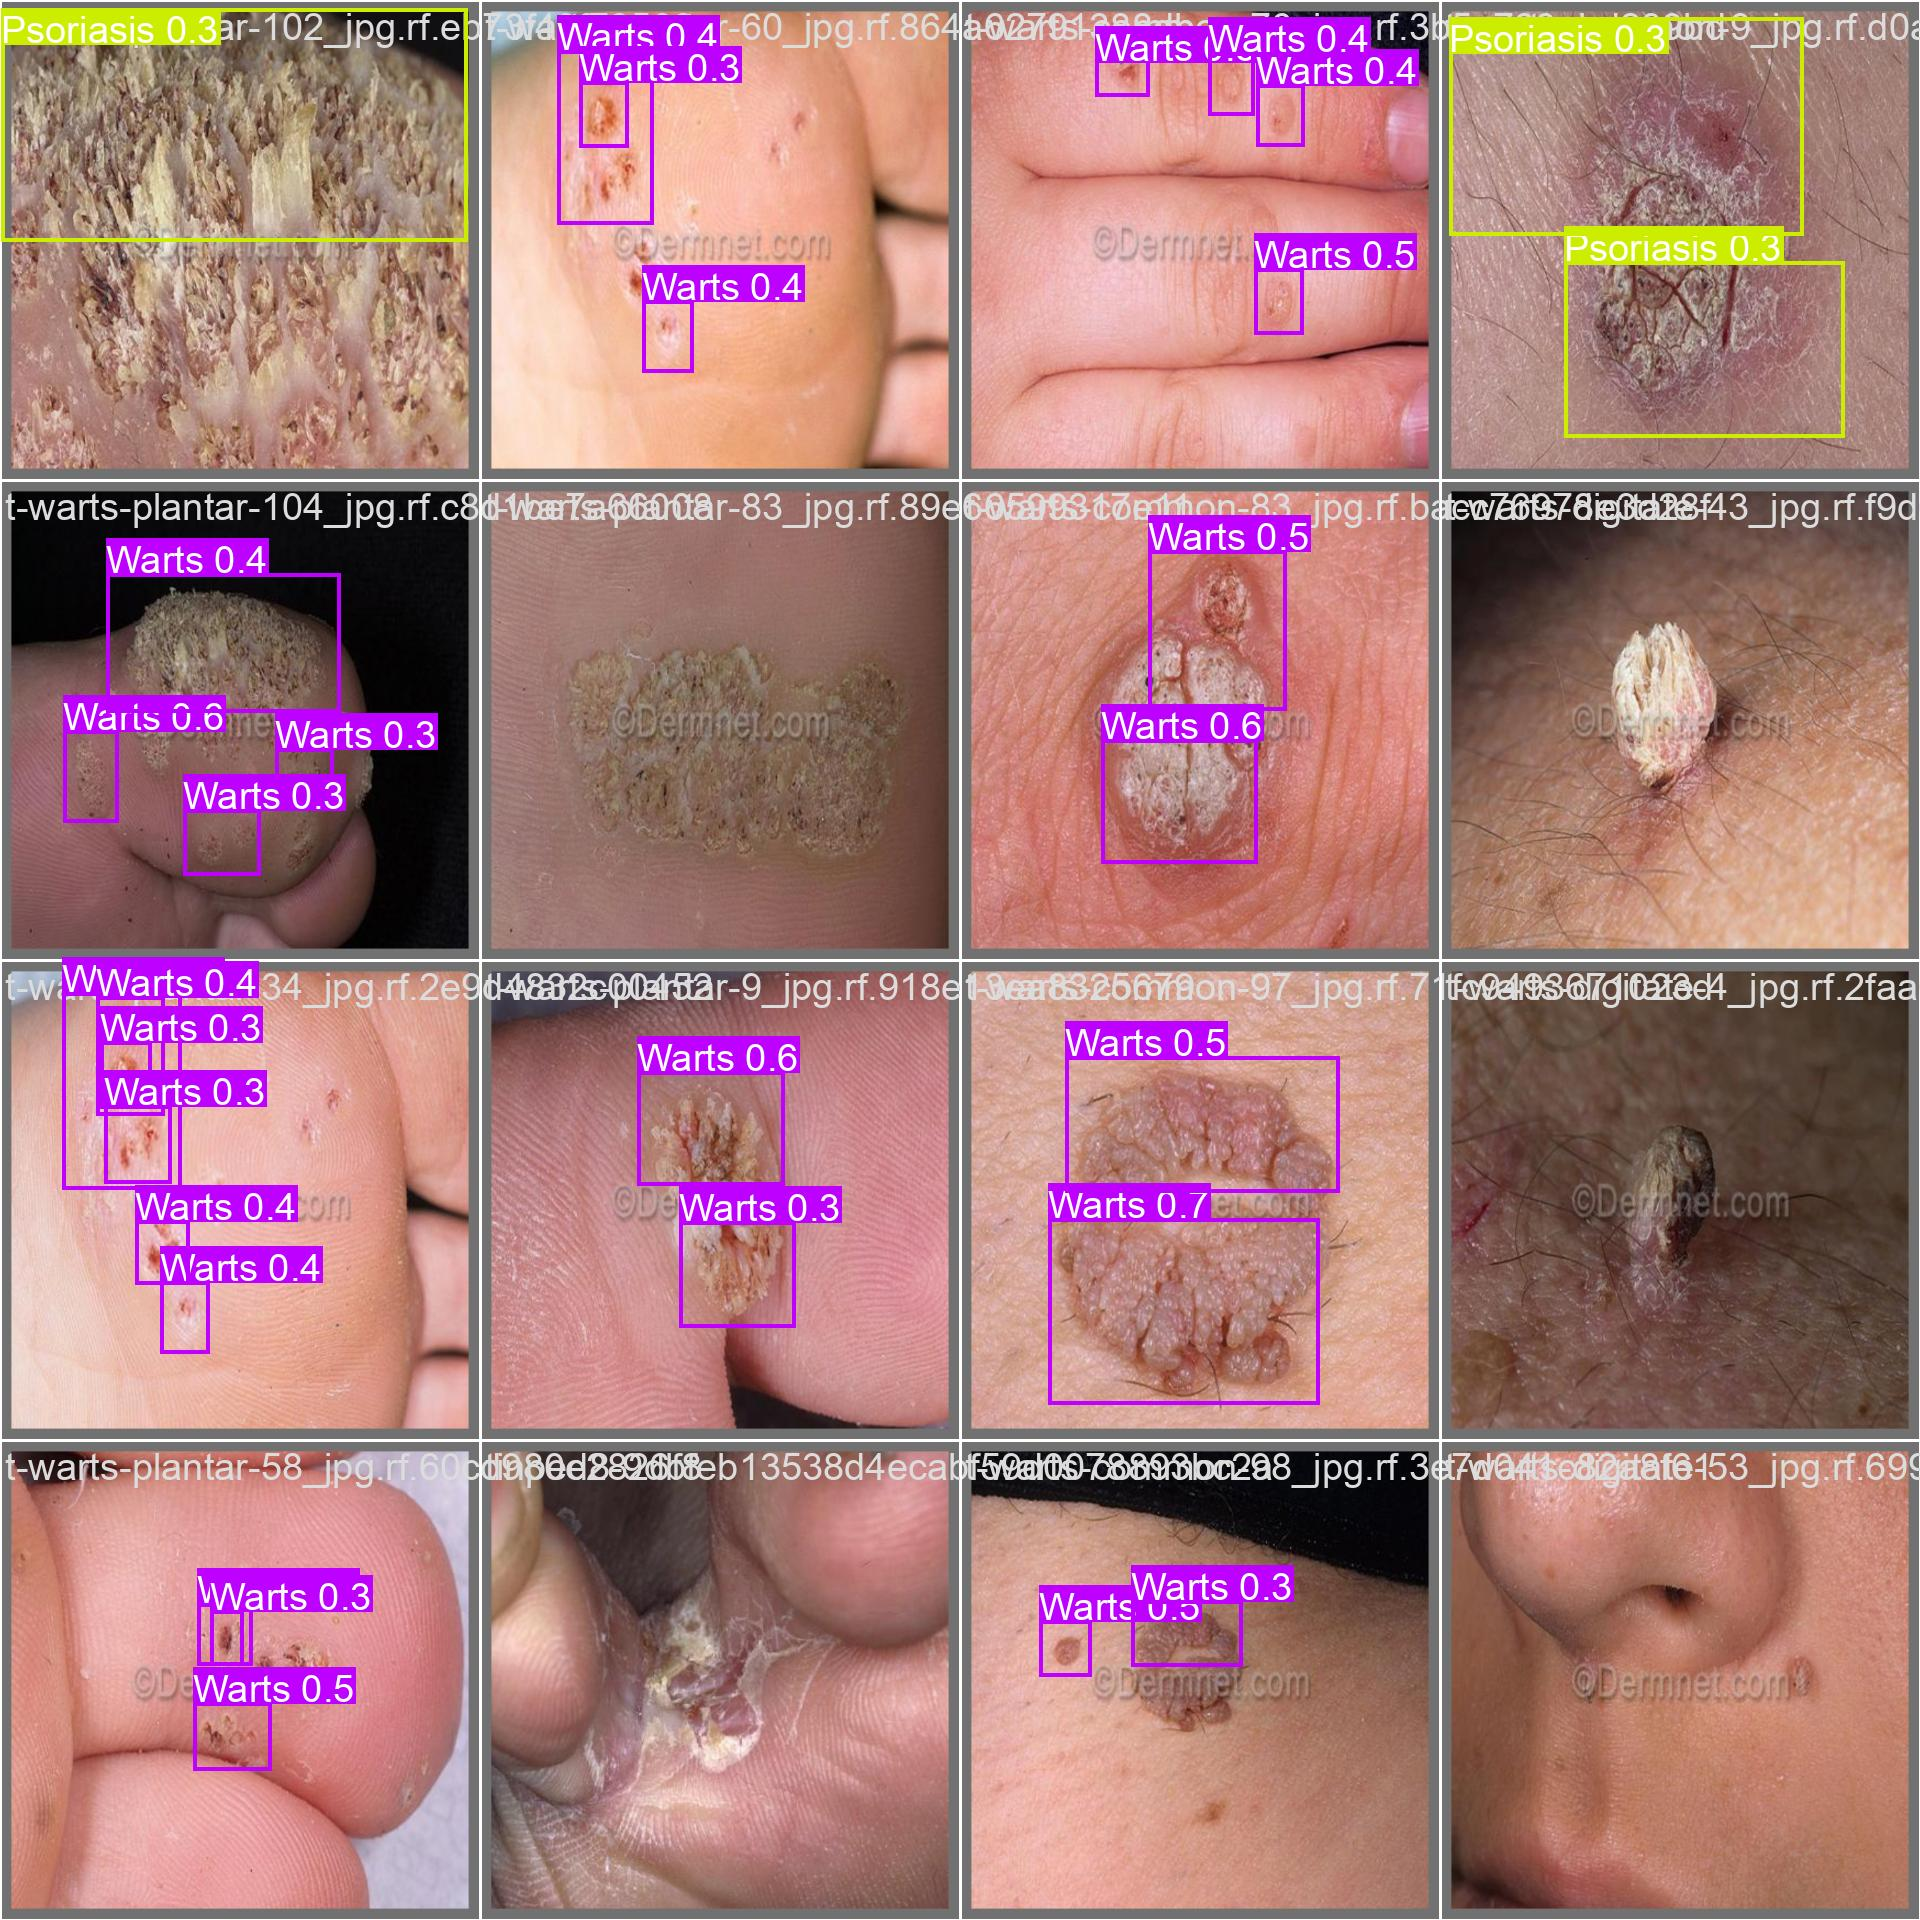

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/poker-cards-4/valid/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100% 44/44 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.13s/it]
                   all         44        197      0.955      0.946      0.985      0.898
           10 of clubs          3          3      0.963          1      0.995       0.94
        10 of diamonds          7          7      0.981          1      0.995      0.959
          10 of hearts          7          7      0.996          1      0.995      0.877
          10 of spades          4          4       0.99          1      0.995      0.692
            2 of clubs          2          2      0.936          1      0.995      0.995
         2 of diamonds          2          2

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs

image 1/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_134701_jpg.rf.27aa29de9d6012ae05c64b156f7c07b8.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 2/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135012_jpg.rf.ee7179374d33235528db011cb5418226.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 3/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135021_jpg.rf.d038afdef1a927103dae268ff392888f.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 4/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_140241_jpg.rf.c44522806b5455bfb03a638aa3ffa896.jpg: 640x640 2 5 of spadess, 1 6 of spades, 2 7 of spadess, 1 8 of spades, 15.7ms
image 5/44 /content/datasets/poker-cards-4/tes

**NOTE:** Let's take a look at few results.

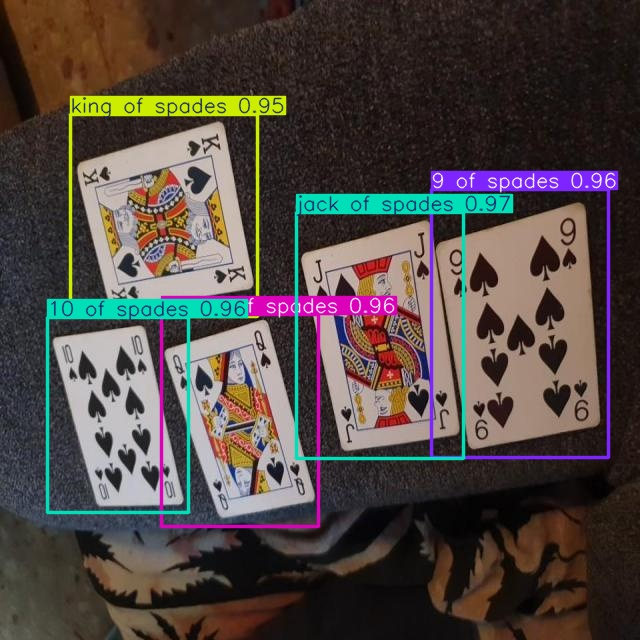

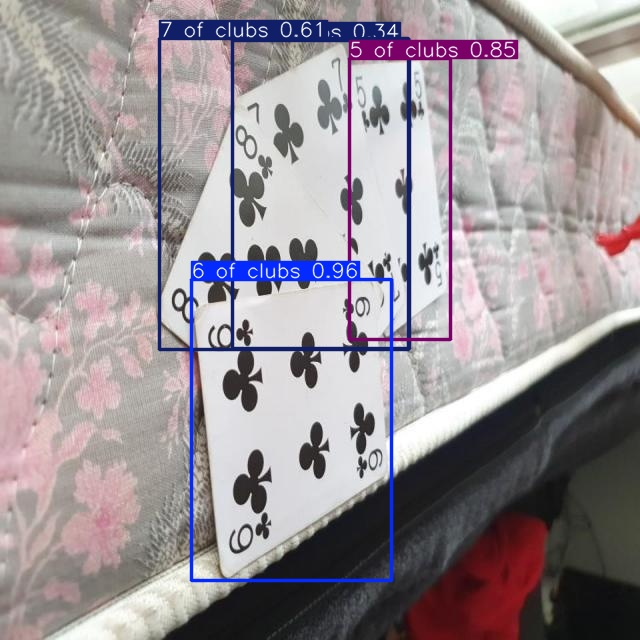

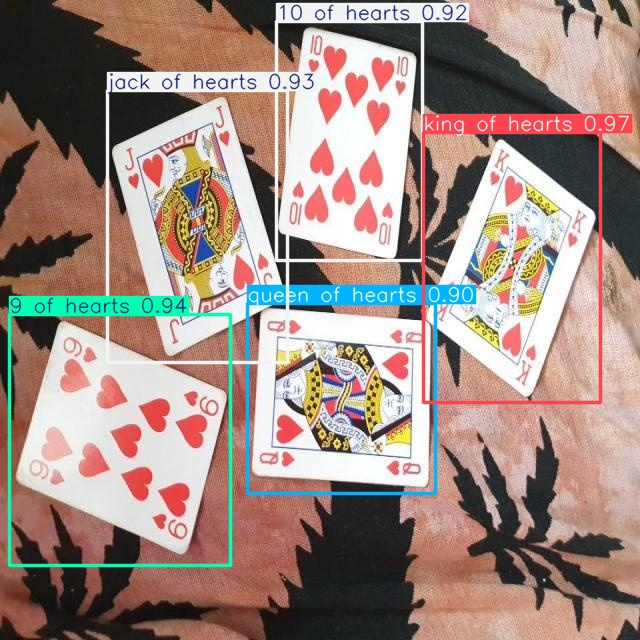

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")